# __MRI DETECTION__

## __PREPROCESSING__

In [40]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

X_train_df = pd.read_csv('X_train.csv').drop('id', axis='columns')
y_train_df = pd.read_csv('y_train.csv').drop('id', axis='columns')

X_test = pd.read_csv('X_test.csv').drop('id', axis='columns')

print(f"shape of X_train_df is : {X_train_df.shape}")
print(f"shape of y_train_df is : {y_train_df.shape}")
print(f"shape of X_test is : {X_test.shape}\n")

shape of X_train_df is : (1212, 832)
shape of y_train_df is : (1212, 1)
shape of X_test is : (776, 832)



## __*IMPUTE VALUES WITH KNN*__

In [41]:
from sklearn.impute import KNNImputer

# NOTE IMPUTING WITH KNN
missing_cols_train = X_train_df.columns[X_train_df.isna().sum() > 0]
missing_cols_test = X_test.columns[X_test.isna().sum() > 0]

print(f"Features with missing values in X_train: {len(missing_cols_train)}")
print(f"Features with missing values in X_test: {len(missing_cols_test)}\n")

imputer = KNNImputer(n_neighbors=5)
X_imp_train = pd.DataFrame(imputer.fit_transform(X_train_df), columns=X_train_df.columns)
X_imp_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

miss_tr_after = X_imp_train.columns[X_imp_train.isna().sum() > 0]
miss_test_after = X_imp_test.columns[X_imp_test.isna().sum() > 0]

print(f"Features with missing values in X_train after imputing: {len(miss_tr_after)}")
print(f"Features with missing values in X_val after imputing: {len(miss_test_after)}")

Features with missing values in X_train: 832
Features with missing values in X_test: 832

Features with missing values in X_train after imputing: 0
Features with missing values in X_val after imputing: 0


## __*REMOVE COSTANT FEATURE (0 VARIANCE)*__

Found 4 constant features: ['x104', 'x129', 'x489', 'x530']


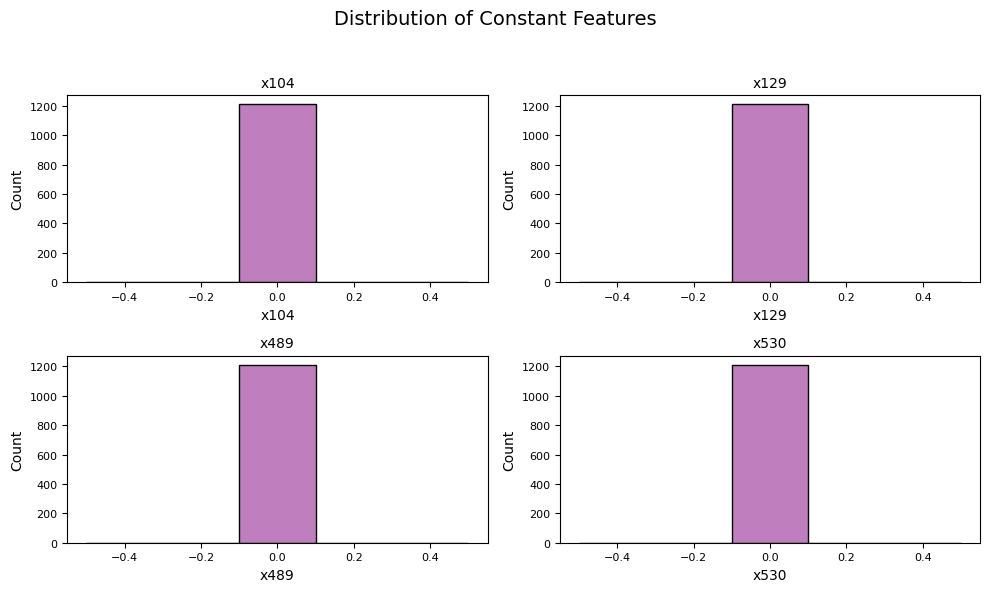


Shape after removing constant features X_impt_train: (1212, 828)
Shape after removing constant features X_imp_test: (776, 828)


In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# NOTE:Remove zero variance features and plot them
constant_features = X_imp_train.columns[X_imp_train.nunique() <= 1]
print(f"Found {len(constant_features)} constant features: {list(constant_features)}")

num = len(constant_features)
if num > 0:
    rows = 2
    cols = 2
    fig, axes = plt.subplots(rows, cols, figsize=(10, 6))
    axes = axes.flatten()

    for i, col in enumerate(constant_features):
        ax = axes[i]
        sns.histplot(X_imp_train[col], bins=5, kde=True, ax=ax, color='purple')
        ax.set_title(col, fontsize=10)
        ax.tick_params(axis='both', which='major', labelsize=8)

    for j in range(num, len(axes)):
        axes[j].axis("off")

    plt.suptitle("Distribution of Constant Features", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
else:
    print("No constant features found.")

# Drop constant features
X_imp_train.drop(columns=constant_features, inplace=True)
X_imp_test.drop(columns=constant_features, inplace=True)

print(f"\nShape after removing constant features X_impt_train: {X_imp_train.shape}")
print(f"Shape after removing constant features X_imp_test: {X_imp_test.shape}")

Removed 55 outliers out of 1212 samples (4.54%)


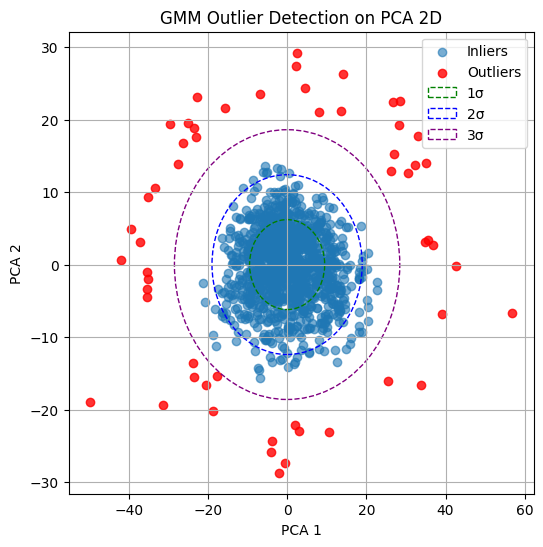

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from matplotlib.patches import Ellipse

def clean_with_gmm_pca2d(X_train, y_train, outlier_percentile=4.5):

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_train)

    pca_2d = PCA(n_components=2, random_state=42)
    X_2d = pca_2d.fit_transform(X_scaled)

    gmm = GaussianMixture(n_components=1, covariance_type='full', random_state=42)
    gmm.fit(X_2d)
    log_likelihood = gmm.score_samples(X_2d)

    threshold = np.percentile(log_likelihood, outlier_percentile)
    mask = log_likelihood >= threshold
    n_outliers = (~mask).sum()
    print(f"Removed {n_outliers} outliers out of {len(X_scaled)} samples ({100*n_outliers/len(X_scaled):.2f}%)")

    X_train_clean = X_train[mask]
    y_train_clean = y_train[mask]

    plt.figure(figsize=(6,6))
    plt.scatter(X_2d[mask, 0], X_2d[mask, 1], label='Inliers', alpha=0.6)
    plt.scatter(X_2d[~mask, 0], X_2d[~mask, 1], label='Outliers', color='red', alpha=0.8)

    def plot_gmm_ellipse(gmm, ax, n_std=2.0, facecolor='none', **kwargs):
        for mean, cov in zip(gmm.means_, gmm.covariances_):
            v, w = np.linalg.eigh(cov)
            order = v.argsort()[::-1]
            v, w = v[order], w[:, order]
            angle = np.degrees(np.arctan2(*w[:,0][::-1]))
            width, height = 2 * n_std * np.sqrt(v)
            ellip = Ellipse(xy=mean, width=width, height=height, angle=angle,
                            facecolor=facecolor, **kwargs)
            ax.add_patch(ellip)

    ax = plt.gca()
    plot_gmm_ellipse(gmm, ax, n_std=1, edgecolor='green', linestyle='--', label='1σ')
    plot_gmm_ellipse(gmm, ax, n_std=2, edgecolor='blue', linestyle='--', label='2σ')
    plot_gmm_ellipse(gmm, ax, n_std=3, edgecolor='purple', linestyle='--', label='3σ')

    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.title('GMM Outlier Detection on PCA 2D')
    plt.legend()
    plt.grid(True)
    plt.show()

    return X_train_clean, y_train_clean, mask, pca_2d, gmm, threshold

X_imp_train, y_train_df, mask_train, pca_2d_train, gmm_train, threshold_train = clean_with_gmm_pca2d(X_imp_train,y_train_df, outlier_percentile=4.5)

# print(f"Cleaned dataset shape X_train: {X_train_clean.shape}")
# print(f"Cleaned dataset shape y_train: {y_train_clean.shape}\n")

## __GRAY MATTER VOLUME__

Found 5 GM-like features:
x384    619429.757943
x385    572101.117836
x414    552549.626299
x620    647452.474630
x682    564672.902569
dtype: float64
x384 min: 619429.70681733 max: 619429.80674722 mean: 619429.7579432626
x385 min: 572101.06822529 max: 572101.16796828 mean: 572101.1178355806
x414 min: 394532.60008886 max: 738228.31524698 mean: 552549.6262986633
x620 min: 647452.42329551 max: 647452.52324221 mean: 647452.4746298423
x682 min: 564672.85337097 max: 564672.95328557 mean: 564672.9025692128


/tmp/ipykernel_717592/3132502017.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_means = X_imp_train[feat].groupby(age_groups).mean()


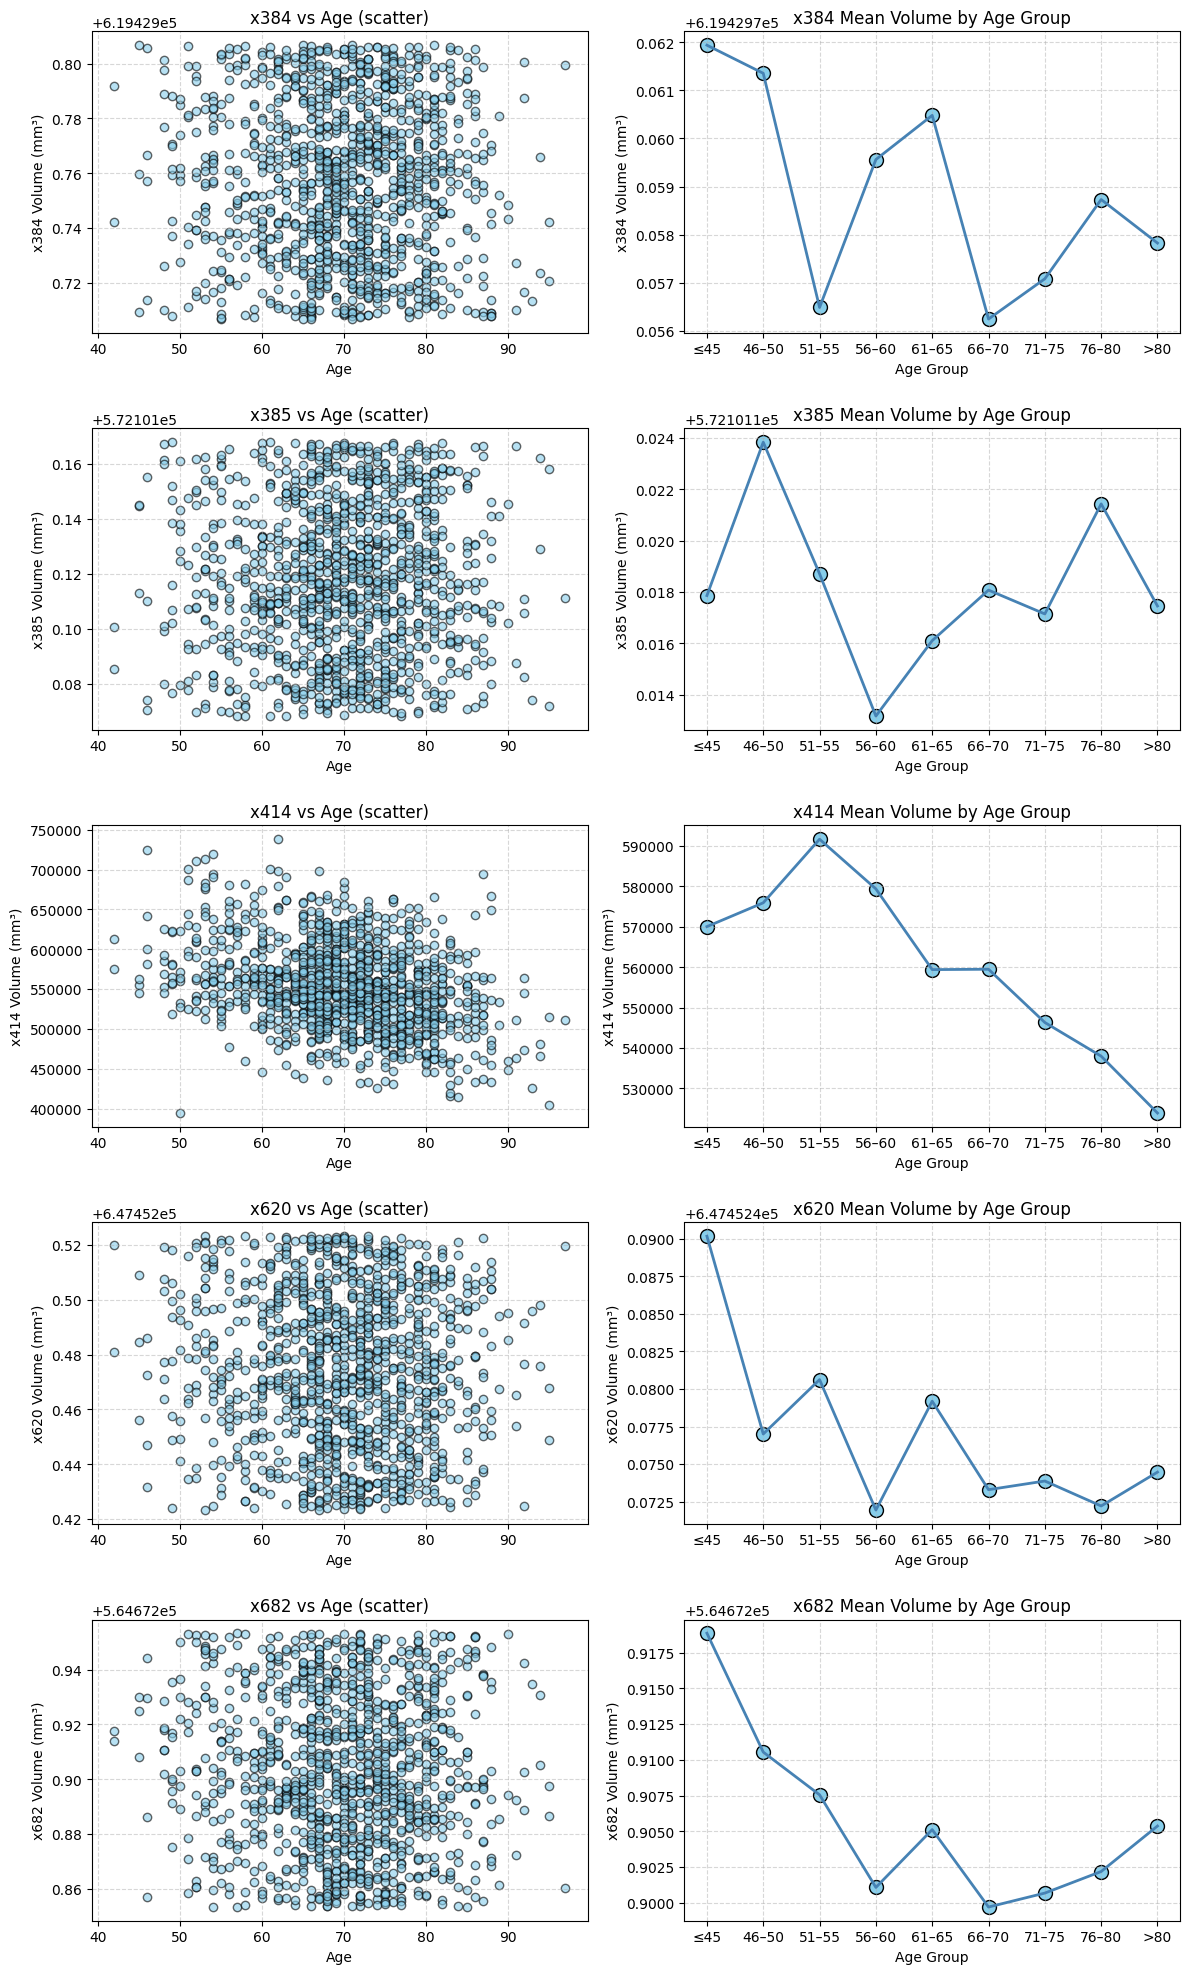

In [ ]:
import matplotlib.pyplot as plt

# Convert y_train_df to Series if needed
y_age = y_train_df.iloc[:, 0] if isinstance(y_train_df, pd.DataFrame) else y_train_df

# GM volume range in mm³
# 553.9 - 599.58
gm_min_mm3 = 540 * 1000  
gm_max_mm3 = 650 * 1000  

# Compute mean of each feature
feature_means = X_imp_train.mean()

# Select GM-like features
gm_like_features = feature_means[(feature_means >= gm_min_mm3) & (feature_means <= gm_max_mm3)]
print(f"Found {len(gm_like_features)} GM-like features:")
print(gm_like_features)

for feat in gm_like_features.index[:10]:
    print(feat,
          "min:", X_imp_train[feat].min(),
          "max:", X_imp_train[feat].max(),
          "mean:", X_imp_train[feat].mean())

# --- Scatter plots of GM-like features vs Age ---
top_features_gm = gm_like_features.index  # Plot top 5 for readability

bins = [0, 45, 50, 55, 60, 65, 70, 75, 80, np.inf]
labels = ['≤45', '46–50', '51–55', '56–60', '61–65', '66–70', '71–75', '76–80', '>80']
age_groups = pd.cut(y_age, bins=bins, labels=labels, right=True)

# Select top features (or all)
top_features_gm = gm_like_features.index[:2]  

# --- Create subplots: 2 columns (scatter & binned mean), n rows = number of features ---
n_rows = len(top_features_gm)
fig, axes = plt.subplots(n_rows, 2, figsize=(12, 4*n_rows), sharey=False)

for i, feat in enumerate(top_features_gm):
    # Left: scatter of individual values vs age
    axes[i, 0].scatter(y_age, X_imp_train[feat], alpha=0.6, color='skyblue', edgecolor='k')
    axes[i, 0].set_title(f'{feat} vs Age (scatter)')
    axes[i, 0].set_xlabel('Age')
    axes[i, 0].set_ylabel(f'{feat} Volume (mm³)')
    axes[i, 0].grid(True, linestyle='--', alpha=0.5)

    # Right: mean per age bin
    grouped_means = X_imp_train[feat].groupby(age_groups).mean()
    axes[i, 1].scatter(grouped_means.index, grouped_means.values, color='skyblue', s=100, edgecolor='k')
    axes[i, 1].plot(grouped_means.index, grouped_means.values, color='steelblue', linewidth=2)
    axes[i, 1].set_title(f'{feat} Mean Volume by Age Group')
    axes[i, 1].set_xlabel('Age Group')
    axes[i, 1].set_ylabel(f'{feat} Volume (mm³)')
    axes[i, 1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

## __WM__

Found 6 GM-like features:
x207    494838.183322
x262    523737.965246
x281    486988.630274
x462    490255.736389
x466    475181.279406
x593    499058.359536
dtype: float64
x207 min: 494838.13510338 max: 494838.23495511 mean: 494838.18332181906
x262 min: 523737.91232576 max: 523738.01208095 mean: 523737.96524646104
x281 min: 486988.58129905 max: 486988.68119944 mean: 486988.6302735729
x462 min: 490255.68535904 max: 490255.7852076 mean: 490255.7363889067
x466 min: 475181.22918967 max: 475181.32888074 mean: 475181.2794055161
x593 min: 499058.31199378 max: 499058.41176034 mean: 499058.3595356062


/tmp/ipykernel_717592/343177497.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_means = X_imp_train[feat].groupby(age_groups).mean()


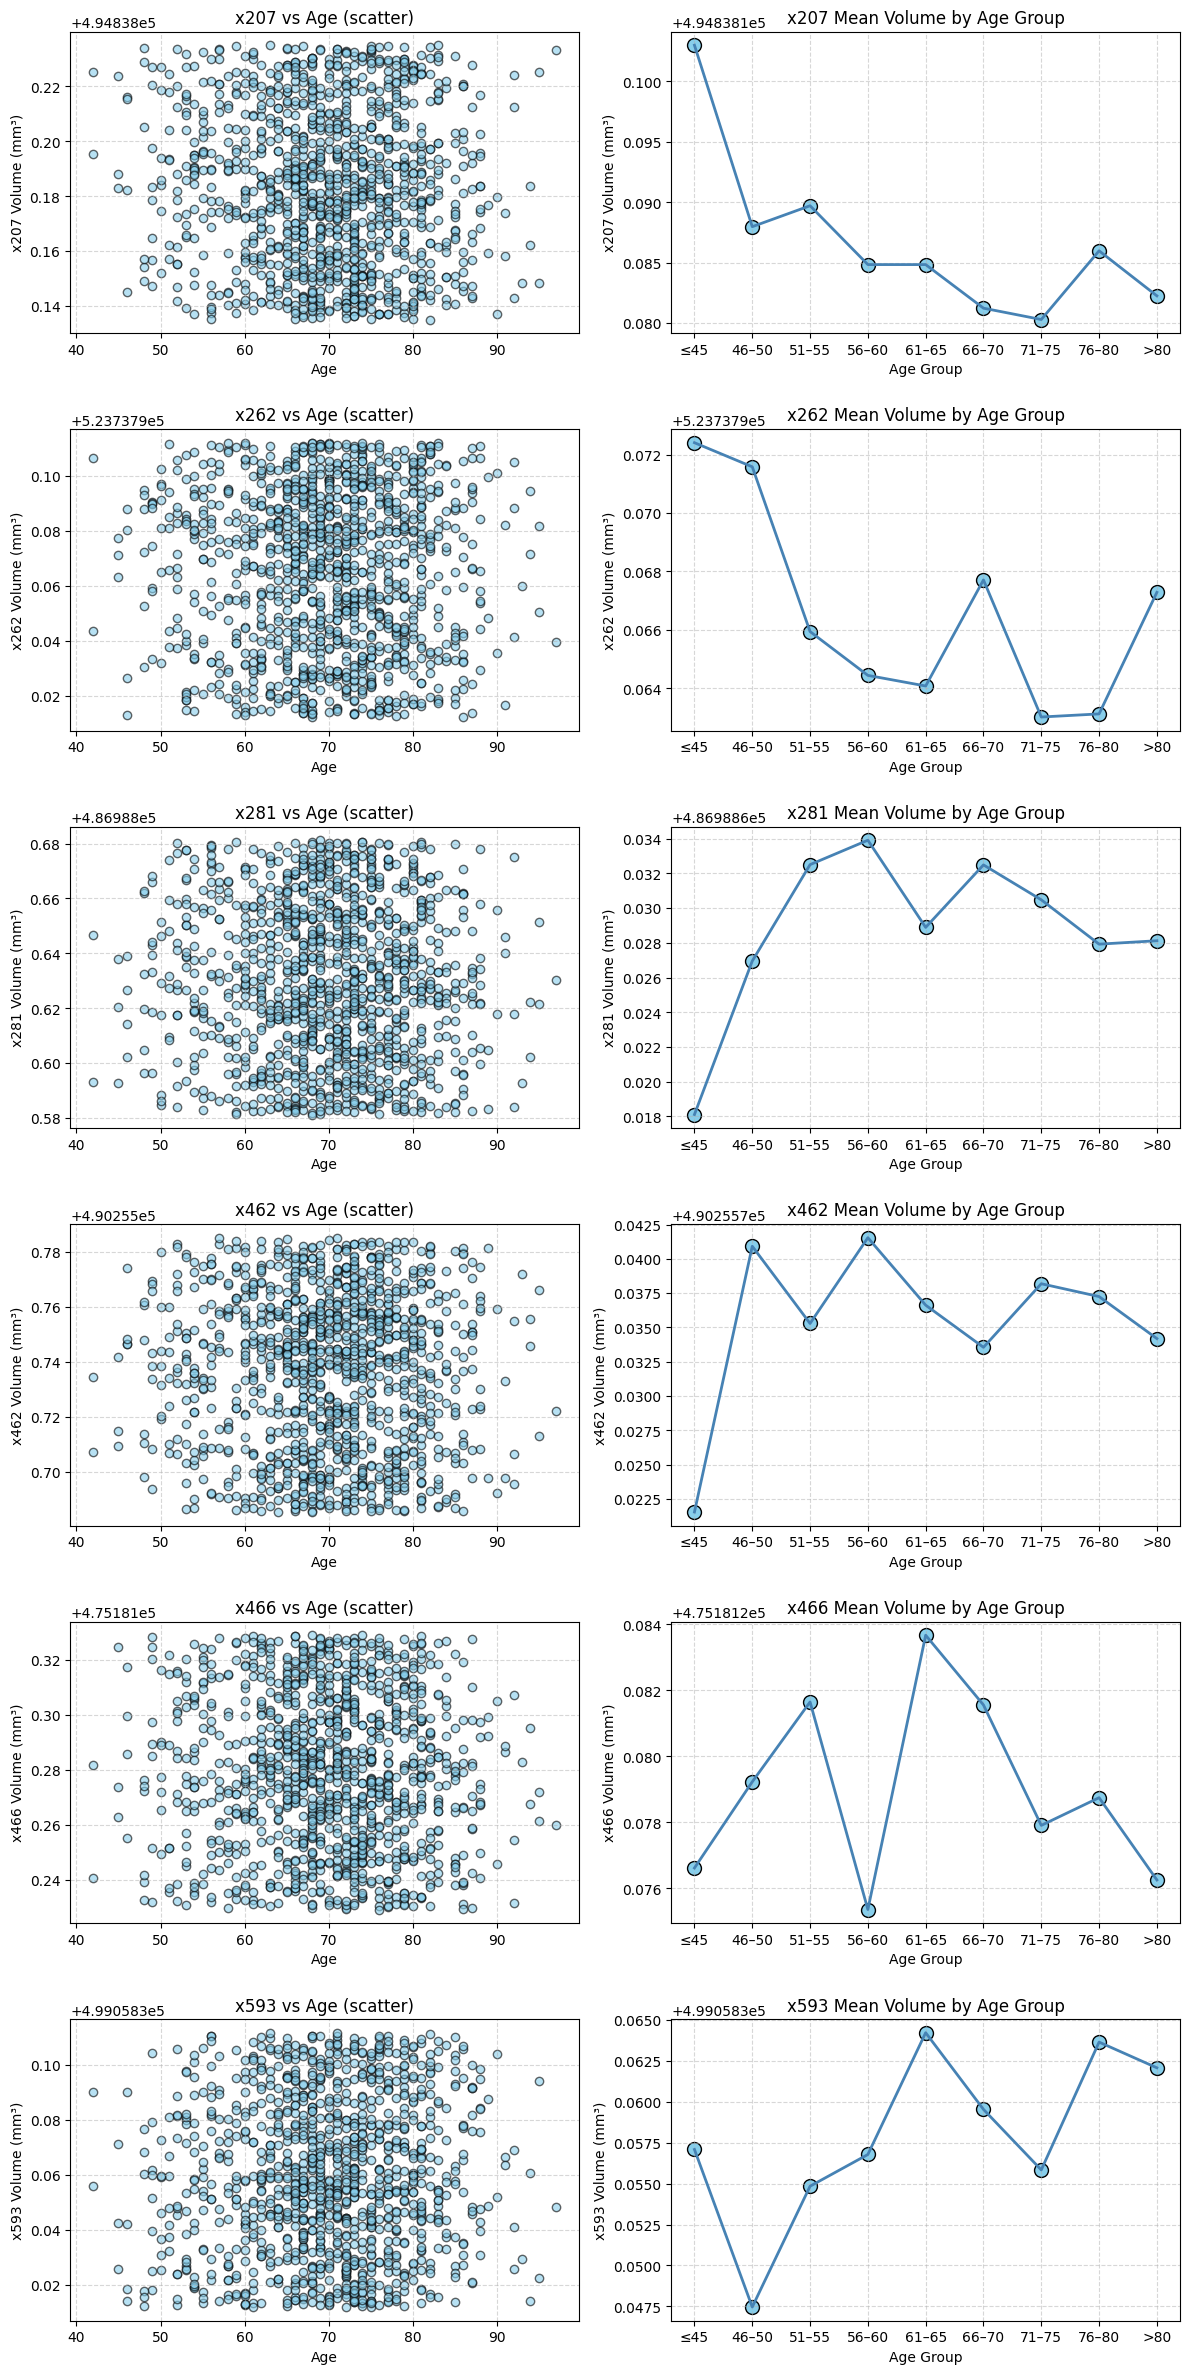

In [ ]:
import matplotlib.pyplot as plt

# Convert y_train_df to Series if needed
y_age = y_train_df.iloc[:, 0] if isinstance(y_train_df, pd.DataFrame) else y_train_df

# 475.8 - 532.9
# GM volume range in mm³
wm_min_mm3 = 451 * 1000  # 553900
wm_max_mm3 = 539 * 1000  # 599580

# Compute mean of each feature
feature_means = X_imp_train.mean()

# Select GM-like features
wm_like_features = feature_means[(feature_means >= wm_min_mm3) & (feature_means <= wm_max_mm3)]
print(f"Found {len(wm_like_features)} GM-like features:")
print(wm_like_features)

for feat in wm_like_features.index[:10]:
    print(feat,
          "min:", X_imp_train[feat].min(),
          "max:", X_imp_train[feat].max(),
          "mean:", X_imp_train[feat].mean())

# --- Scatter plots of GM-like features vs Age ---
# --- Scatter plots of GM-like features vs Age ---
top_features_wm = wm_like_features.index  # Plot top 5 for readability

bins = [0, 45, 50, 55, 60, 65, 70, 75, 80, np.inf]
labels = ['≤45', '46–50', '51–55', '56–60', '61–65', '66–70', '71–75', '76–80', '>80']
age_groups = pd.cut(y_age, bins=bins, labels=labels, right=True)

# Select top features (or all)
top_features_wm = wm_like_features.index[:2]  # top 5 for readability

# --- Create subplots: 2 columns (scatter & binned mean), n rows = number of features ---
n_rows = len(top_features_wm)
fig, axes = plt.subplots(n_rows, 2, figsize=(12, 4*n_rows), sharey=False)

for i, feat in enumerate(top_features_wm):
    # Left: scatter of individual values vs age
    axes[i, 0].scatter(y_age, X_imp_train[feat], alpha=0.6, color='skyblue', edgecolor='k')
    axes[i, 0].set_title(f'{feat} vs Age (scatter)')
    axes[i, 0].set_xlabel('Age')
    axes[i, 0].set_ylabel(f'{feat} Volume (mm³)')
    axes[i, 0].grid(True, linestyle='--', alpha=0.5)

    # Right: mean per age bin
    grouped_means = X_imp_train[feat].groupby(age_groups).mean()
    axes[i, 1].scatter(grouped_means.index, grouped_means.values, color='skyblue', s=100, edgecolor='k')
    axes[i, 1].plot(grouped_means.index, grouped_means.values, color='steelblue', linewidth=2)
    axes[i, 1].set_title(f'{feat} Mean Volume by Age Group')
    axes[i, 1].set_xlabel('Age Group')
    axes[i, 1].set_ylabel(f'{feat} Volume (mm³)')
    axes[i, 1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

## __CFS__

Found 9 GM-like features:
x185    363704.311085
x295    388843.502354
x307    372663.102065
x492    357883.294165
x550    339510.185727
x666    349429.995173
x668    427393.987411
x675    409217.297284
x808    368045.117241
dtype: float64
x185 min: 363704.2616998 max: 363704.3616919 mean: 363704.3110847158
x295 min: 388843.45142709 max: 388843.55140818 mean: 388843.50235404755
x307 min: 372663.05125728 max: 372663.15118039 mean: 372663.10206496075
x492 min: 357883.24461822 max: 357883.3444171 mean: 357883.29416479764
x550 min: 339510.13537466 max: 339510.23503956 mean: 339510.1857265339
x666 min: 349429.94659632 max: 349430.04646383 mean: 349429.99517302326
x668 min: 253829.0760318 max: 630785.81756755 mean: 427393.9874109153
x675 min: 296575.62179915 max: 554544.83882351 mean: 409217.29728394403
x808 min: 368045.06904324 max: 368045.16894008 mean: 368045.1172406388


/tmp/ipykernel_717592/1751413696.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_means = X_imp_train[feat].groupby(age_groups).mean()


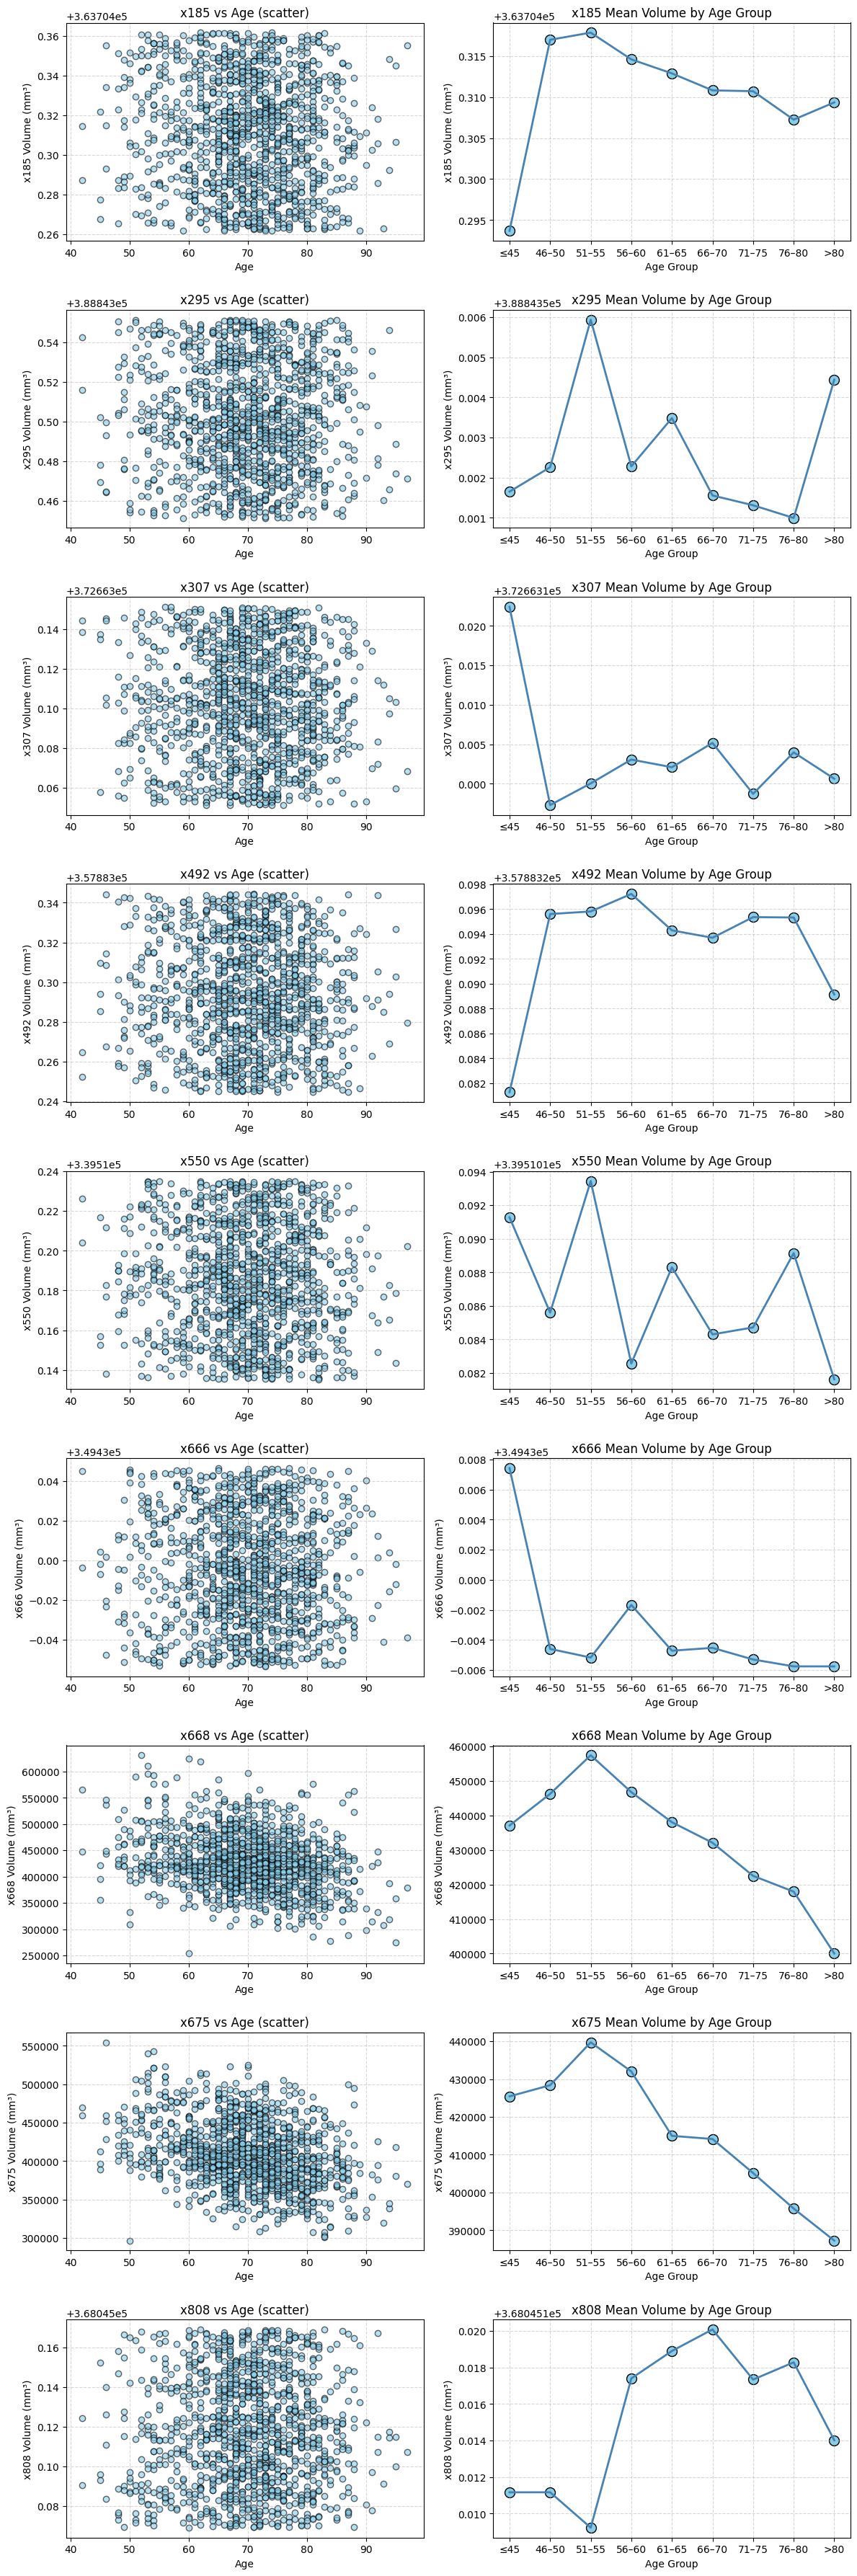

In [ ]:
import matplotlib.pyplot as plt

# Convert y_train_df to Series if needed
y_age = y_train_df.iloc[:, 0] if isinstance(y_train_df, pd.DataFrame) else y_train_df

# GM volume range in mm³
# 349.8 - 420
cfs_min_mm3 = 330 * 1000  
cfs_max_mm3 = 450 * 1000  

# Compute mean of each feature
feature_means = X_imp_train.mean()

# Select GM-like features
cfs_like_features = feature_means[(feature_means >= cfs_min_mm3) & (feature_means <= cfs_max_mm3)]
print(f"Found {len(cfs_like_features)} GM-like features:")
print(cfs_like_features)

for feat in cfs_like_features.index[:10]:
    print(feat,
          "min:", X_imp_train[feat].min(),
          "max:", X_imp_train[feat].max(),
          "mean:", X_imp_train[feat].mean())

top_features_cfs = cfs_like_features.index


bins = [0, 45, 50, 55, 60, 65, 70, 75, 80, np.inf]
labels = ['≤45', '46–50', '51–55', '56–60', '61–65', '66–70', '71–75', '76–80', '>80']
age_groups = pd.cut(y_age, bins=bins, labels=labels, right=True)

# Select top features (or all)
top_features_cfs = cfs_like_features.index[:2]  

# --- Create subplots: 2 columns (scatter & binned mean), n rows = number of features ---
n_rows = len(top_features_cfs)
fig, axes = plt.subplots(n_rows, 2, figsize=(12, 4*n_rows), sharey=False)

for i, feat in enumerate(top_features_cfs):
    # Left: scatter of individual values vs age
    axes[i, 0].scatter(y_age, X_imp_train[feat], alpha=0.6, color='skyblue', edgecolor='k')
    axes[i, 0].set_title(f'{feat} vs Age (scatter)')
    axes[i, 0].set_xlabel('Age')
    axes[i, 0].set_ylabel(f'{feat} Volume (mm³)')
    axes[i, 0].grid(True, linestyle='--', alpha=0.5)

    # Right: mean per age bin
    grouped_means = X_imp_train[feat].groupby(age_groups).mean()
    axes[i, 1].scatter(grouped_means.index, grouped_means.values, color='skyblue', s=100, edgecolor='k')
    axes[i, 1].plot(grouped_means.index, grouped_means.values, color='steelblue', linewidth=2)
    axes[i, 1].set_title(f'{feat} Mean Volume by Age Group')
    axes[i, 1].set_xlabel('Age Group')
    axes[i, 1].set_ylabel(f'{feat} Volume (mm³)')
    axes[i, 1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

## __NEGATIVE CORRELATION__

/tmp/ipykernel_717592/2463898820.py:41: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_means = X_imp_train[feat].groupby(age_groups).mean()


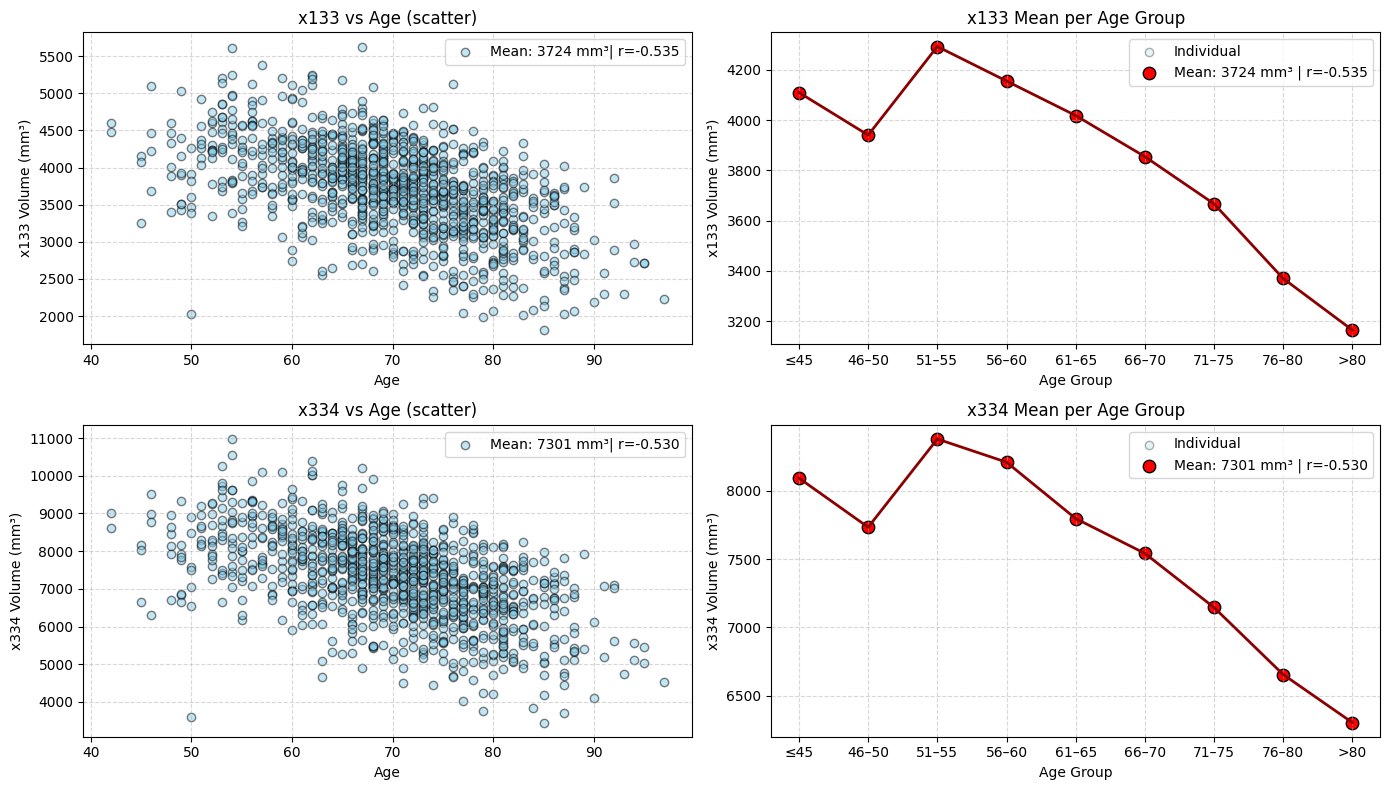

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations

# Ensure y is a Series
if isinstance(y_train_df, pd.DataFrame):
    y_age = y_train_df.iloc[:, 0]
else:
    y_age = y_train_df

# Compute correlation of each feature with Age
corr_with_age = X_imp_train.apply(lambda x: np.corrcoef(x, y_age)[0, 1])
corr_sorted = corr_with_age.sort_values()

# Select top 5 negatively correlated features
top_features_negative = corr_sorted.index[:17]

# Define age bins
bins = [0, 45, 50, 55, 60, 65, 70, 75, 80, np.inf]
labels = ['≤45', '46–50', '51–55', '56–60', '61–65', '66–70', '71–75', '76–80', '>80']
age_groups = pd.cut(y_age, bins=bins, labels=labels, right=True)

# --- Create subplots: 2 columns (scatter & binned mean), n rows = number of features ---
n_rows = len(top_features_negative[:2])
fig, axes = plt.subplots(n_rows, 2, figsize=(14, 4*n_rows), sharey=False)

for i, feat in enumerate(top_features_negative[:2]):
    feat_mean = X_imp_train[feat].mean()  # compute mean
    feat_corr = corr_with_age[feat]
    
    # Left: scatter of individual values
    axes[i, 0].scatter(y_age, X_imp_train[feat], alpha=0.5, color='skyblue', edgecolor='k', label=f'Mean: {feat_mean:.0f} mm³| r={feat_corr:.3f}')
    axes[i, 0].set_title(f'{feat} vs Age (scatter)')
    axes[i, 0].set_xlabel('Age')
    axes[i, 0].set_ylabel(f'{feat} Volume (mm³)')
    axes[i, 0].grid(True, linestyle='--', alpha=0.5)
    axes[i, 0].legend()
    
    # Right: scatter + line of mean per age bin
    grouped_means = X_imp_train[feat].groupby(age_groups).mean()
    axes[i, 1].scatter(y_age, X_imp_train[feat], alpha=0.3, color='lightblue', edgecolor='k', label='Individual')
    axes[i, 1].scatter(grouped_means.index, grouped_means.values, color='red', s=80, edgecolor='k', label=f'Mean: {feat_mean:.0f} mm³ | r={feat_corr:.3f}')
    axes[i, 1].plot(grouped_means.index, grouped_means.values, color='darkred', linewidth=2)
    axes[i, 1].set_title(f'{feat} Mean per Age Group')
    axes[i, 1].set_xlabel('Age Group')
    axes[i, 1].set_ylabel(f'{feat} Volume (mm³)')
    axes[i, 1].grid(True, linestyle='--', alpha=0.5)
    axes[i, 1].legend()

plt.tight_layout()
plt.show()


## __POSITIVE CORRELATIONS__

/tmp/ipykernel_717592/610440109.py:40: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_means = X_imp_train[feat].groupby(age_groups).mean()


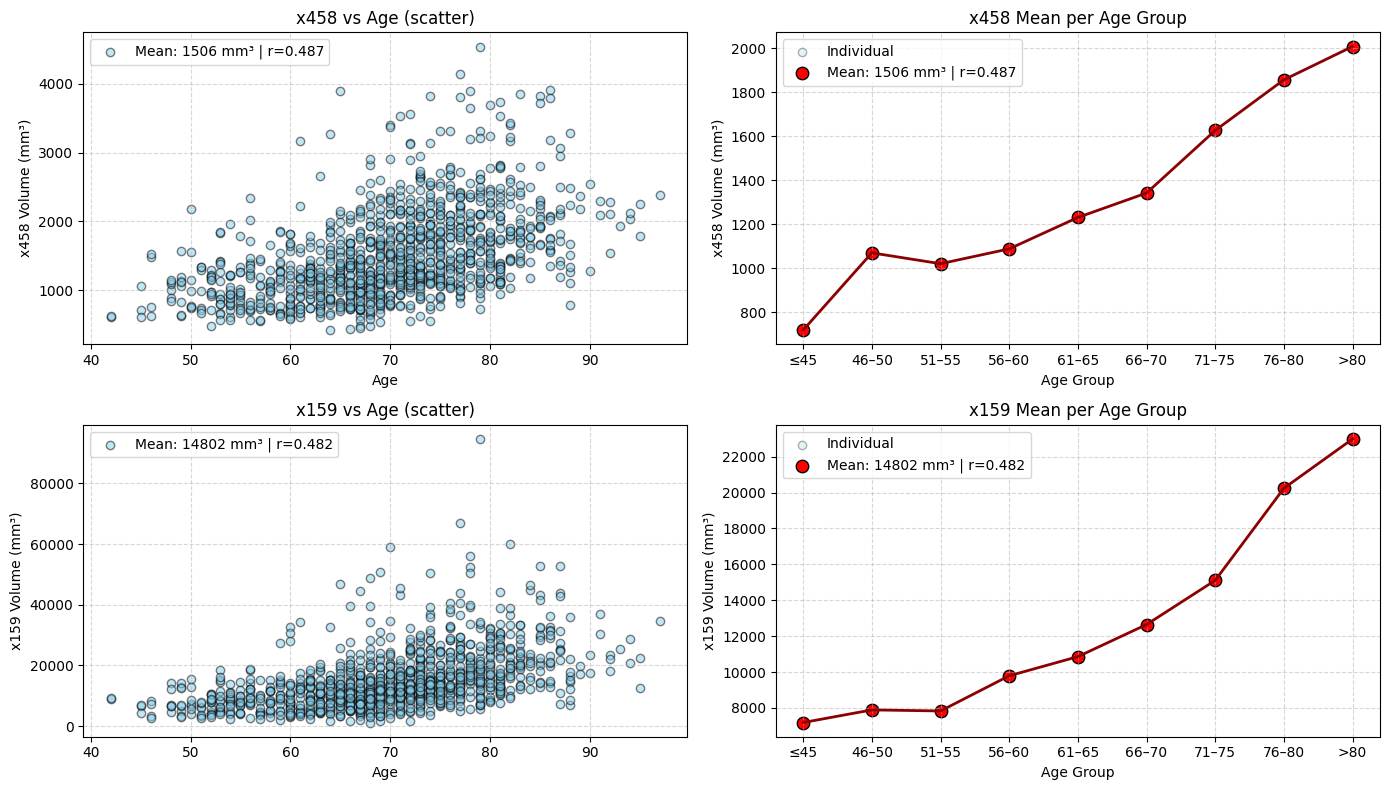

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Ensure y is a Series
if isinstance(y_train_df, pd.DataFrame):
    y_age = y_train_df.iloc[:, 0]
else:
    y_age = y_train_df

# Compute correlation of each feature with Age
corr_with_age = X_imp_train.apply(lambda x: np.corrcoef(x, y_age)[0, 1])
corr_sorted = corr_with_age.sort_values(ascending=False)

# Select top 5 negatively correlated features
top_features_positive = corr_sorted.index[:17]

# Define age bins
bins = [0, 45, 50, 55, 60, 65, 70, 75, 80, np.inf]
labels = ['≤45', '46–50', '51–55', '56–60', '61–65', '66–70', '71–75', '76–80', '>80']
age_groups = pd.cut(y_age, bins=bins, labels=labels, right=True)

# --- Create subplots: 2 columns (scatter & binned mean), n rows = number of features ---
n_rows = len(top_features_positive[:2])
fig, axes = plt.subplots(n_rows, 2, figsize=(14, 4*n_rows), sharey=False)

for i, feat in enumerate(top_features_positive[:2]):
    feat_mean = X_imp_train[feat].mean()  # compute mean
    feat_corr = corr_with_age[feat]
    
    # Left: scatter of individual values
    axes[i, 0].scatter(y_age, X_imp_train[feat], alpha=0.5, color='skyblue', edgecolor='k', label=f'Mean: {feat_mean:.0f} mm³ | r={feat_corr:.3f}')
    axes[i, 0].set_title(f'{feat} vs Age (scatter)')
    axes[i, 0].set_xlabel('Age')
    axes[i, 0].set_ylabel(f'{feat} Volume (mm³)')
    axes[i, 0].grid(True, linestyle='--', alpha=0.5)
    axes[i, 0].legend()
    
    # Right: scatter + line of mean per age bin
    grouped_means = X_imp_train[feat].groupby(age_groups).mean()
    axes[i, 1].scatter(y_age, X_imp_train[feat], alpha=0.3, color='lightblue', edgecolor='k', label='Individual')
    axes[i, 1].scatter(grouped_means.index, grouped_means.values, color='red', s=80, edgecolor='k', label=f'Mean: {feat_mean:.0f} mm³ | r={feat_corr:.3f}')
    axes[i, 1].plot(grouped_means.index, grouped_means.values, color='darkred', linewidth=2)
    axes[i, 1].set_title(f'{feat} Mean per Age Group')
    axes[i, 1].set_xlabel('Age Group')
    axes[i, 1].set_ylabel(f'{feat} Volume (mm³)')
    axes[i, 1].grid(True, linestyle='--', alpha=0.5)
    axes[i, 1].legend()

plt.tight_layout()
plt.show()


## __NON-LINEAR CORR__

✅ Added 80 squared features to each dataset.
New train shape: (1157, 908)
✅ Added 80 squared features to each dataset.
New train shape: (1157, 908)


/tmp/ipykernel_717592/2149340232.py:76: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_means = X_imp_train[feat].groupby(age_groups).mean()


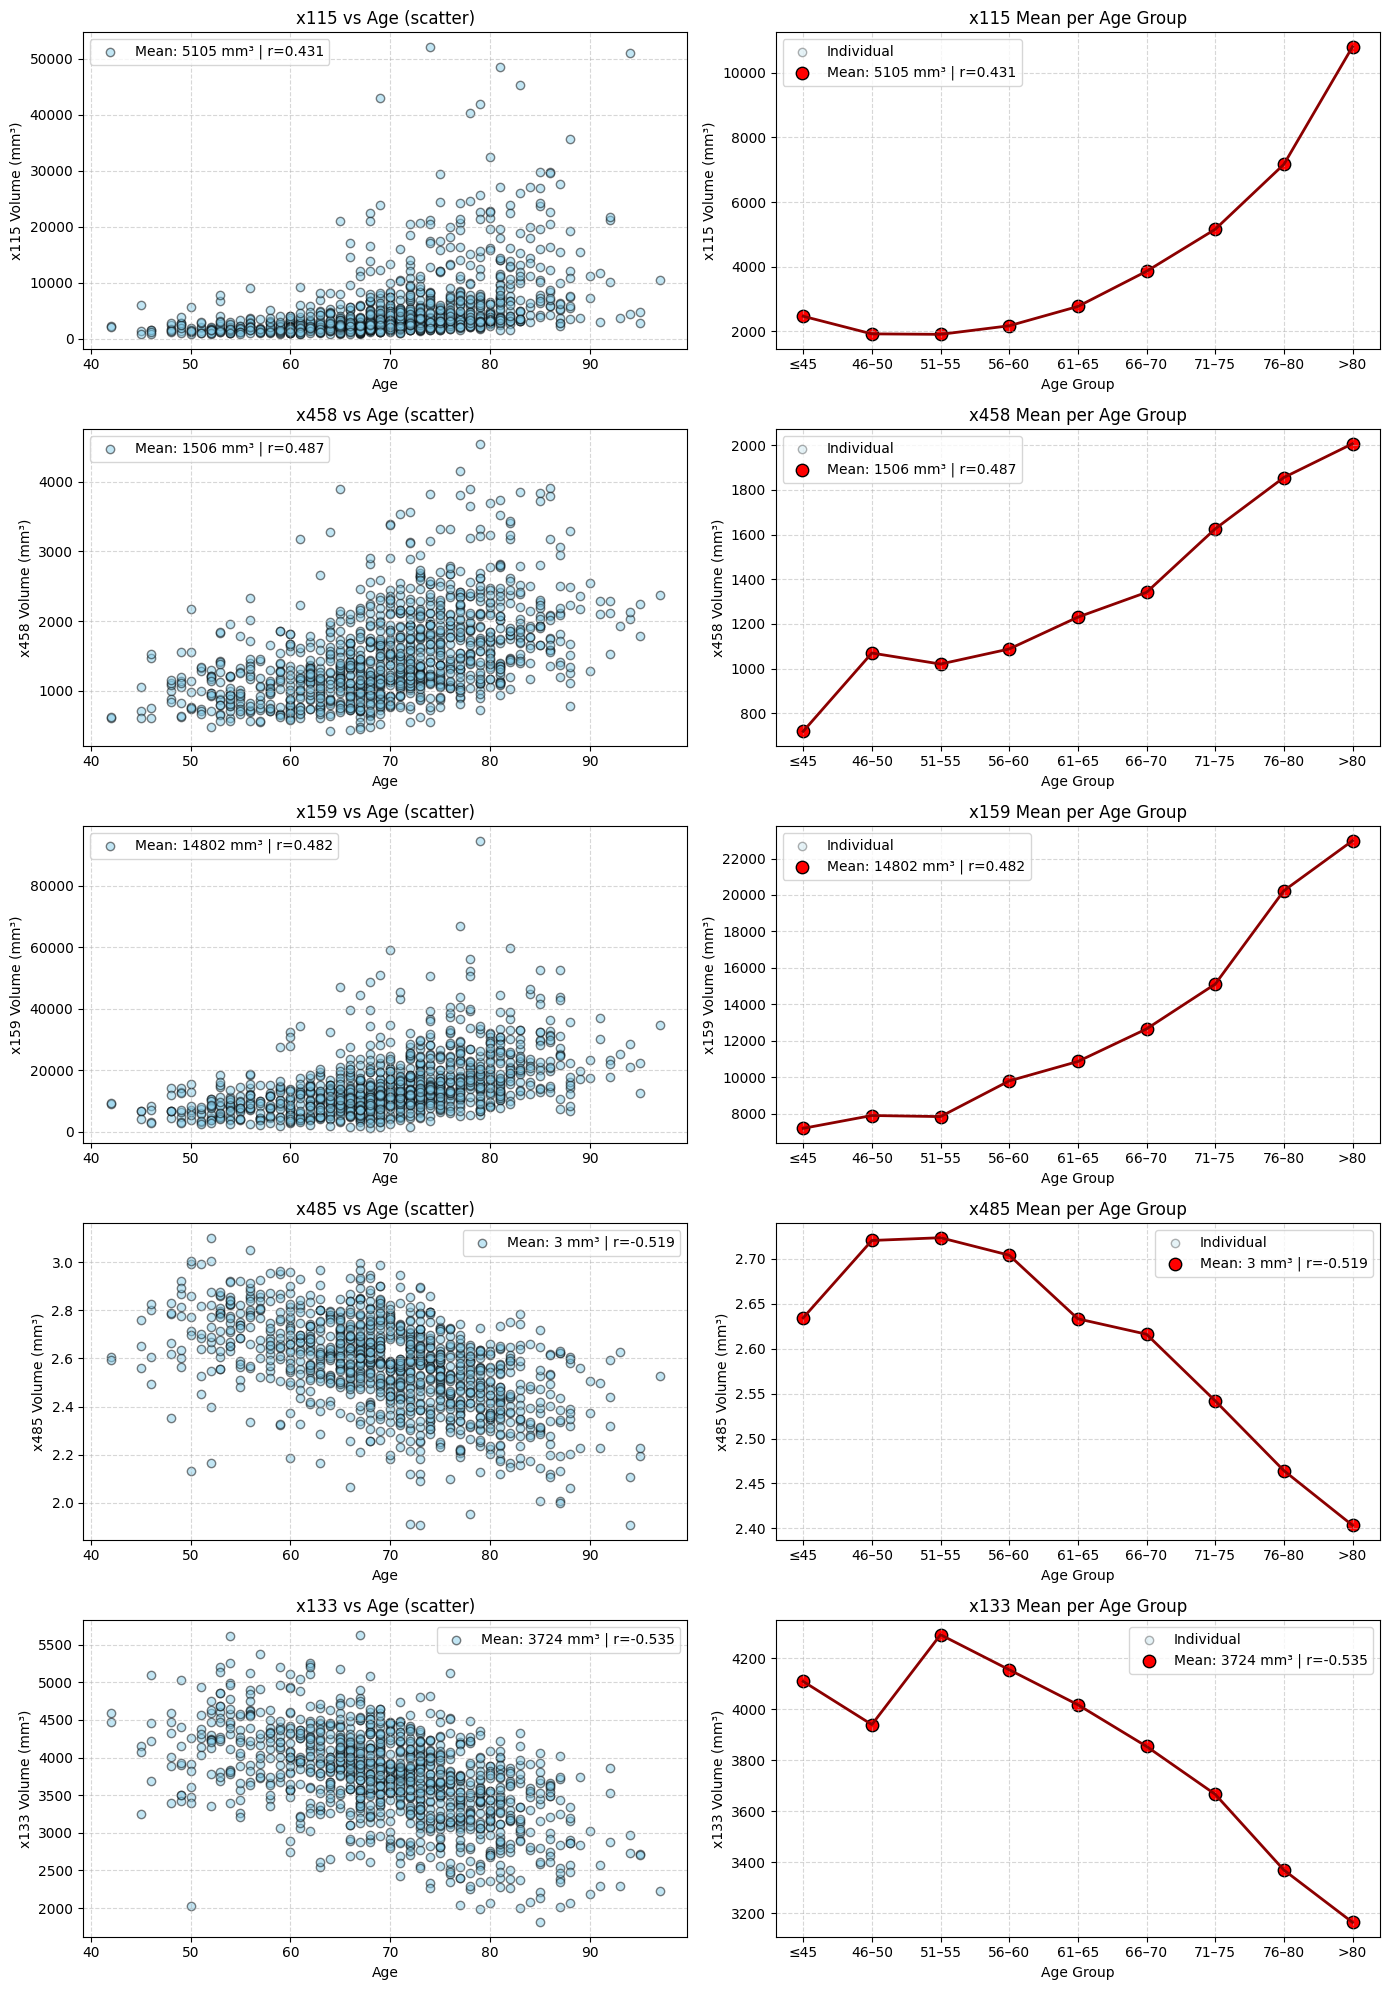

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression
from itertools import combinations


y_age = y_train_df.iloc[:, 0] if isinstance(y_train_df, pd.DataFrame) else y_train_df

# --- Compute mutual information between each feature and age ---
mi_scores = mutual_info_regression(X_imp_train, y_age, random_state=42)
mi_scores_series = pd.Series(mi_scores, index=X_imp_train.columns)
mi_sorted = mi_scores_series.sort_values(ascending=False)

# Select top 50 features by mutual information
top_features_mi = mi_sorted.index[:110]

top_features_30 = mi_sorted.index[:80]

# top_features_60 = mi_sorted.index[90:100]

# --- Add squared versions of those features (new columns) ---
for feat in top_features_30:
    X_imp_train[f"{feat}_squared"] = X_imp_train[feat] ** 2
    if 'X_imp_test' in locals():
        X_imp_test[f"{feat}_squared"] = X_imp_test[feat] ** 2

print(f"✅ Added {len(top_features_30)} squared features to each dataset.")
print(f"New train shape: {X_imp_train.shape}")

# # ADD cube
# for feat in top_features_60:
#     X_imp_train[f"{feat}_cube"] = X_imp_train[feat] ** 3
#     if 'X_imp_test' in locals():
#         X_imp_test[f"{feat}_cube"] = X_imp_test[feat] ** 3


# top_20_features = top_features_mi[:10]

# for f1, f2 in combinations(top_20_features, 2):
#     X_imp_train[f"{f1}_x_{f2}"] = X_imp_train[f1] * X_imp_train[f2]
#     if 'X_imp_test' in locals():
#         X_imp_test[f"{f1}_x_{f2}"] = X_imp_test[f1] * X_imp_test[f2]

print(f"✅ Added {len(top_features_30)} squared features to each dataset.")
print(f"New train shape: {X_imp_train.shape}")

# --- Compute correlation for plotting ---
corr_with_age = X_imp_train[top_features_mi].apply(lambda x: np.corrcoef(x, y_age)[0,1])

# Define age bins
bins = [0, 45, 50, 55, 60, 65, 70, 75, 80, np.inf]
labels = ['≤45', '46–50', '51–55', '56–60', '61–65', '66–70', '71–75', '76–80', '>80']
age_groups = pd.cut(y_age, bins=bins, labels=labels, right=True)


# --- Plot first 15 features ---
top_features_plot = top_features_mi[:5]
n_rows = len(top_features_plot)
fig, axes = plt.subplots(n_rows, 2, figsize=(14, 4*n_rows), sharey=False)

for i, feat in enumerate(top_features_plot):
    feat_mean = X_imp_train[feat].mean()
    feat_corr = corr_with_age[feat]

    # Left: scatter of individual values
    axes[i, 0].scatter(y_age, X_imp_train[feat], alpha=0.5, color='skyblue', edgecolor='k',
                       label=f'Mean: {feat_mean:.0f} mm³ | r={feat_corr:.3f}')
    axes[i, 0].set_title(f'{feat} vs Age (scatter)')
    axes[i, 0].set_xlabel('Age')
    axes[i, 0].set_ylabel(f'{feat} Volume (mm³)')
    axes[i, 0].grid(True, linestyle='--', alpha=0.5)
    axes[i, 0].legend()

    # Right: scatter + line of mean per age bin
    grouped_means = X_imp_train[feat].groupby(age_groups).mean()
    axes[i, 1].scatter(y_age, X_imp_train[feat], alpha=0.3, color='lightblue', edgecolor='k', label='Individual')
    axes[i, 1].scatter(grouped_means.index, grouped_means.values, color='red', s=80, edgecolor='k',
                       label=f'Mean: {feat_mean:.0f} mm³ | r={feat_corr:.3f}')
    axes[i, 1].plot(grouped_means.index, grouped_means.values, color='darkred', linewidth=2)
    axes[i, 1].set_title(f'{feat} Mean per Age Group')
    axes[i, 1].set_xlabel('Age Group')
    axes[i, 1].set_ylabel(f'{feat} Volume (mm³)')
    axes[i, 1].grid(True, linestyle='--', alpha=0.5)
    axes[i, 1].legend()

plt.tight_layout()
plt.show()


## __CREATE DATAFRAME__

In [52]:
# NOTE: only ones that have correlation
# Filter only existing features
existing_cfs = [f for f in ['x675', 'x668'] if f in top_features_cfs]
existing_gm = [f for f in ['x414'] if f in top_features_gm]
merged_features = pd.Index(existing_gm + existing_cfs)
print(merged_features)

squared_features = [f"{feat}_squared" for feat in top_features_30 if f"{feat}_squared" in X_imp_train.columns]

# cube_features = [f"{feat}_cube" for feat in top_features_60 if f"{feat}_cube" in X_imp_train.columns]

# --- Combine features as a list ---
all_selected_features = list(
    pd.Index(top_features_positive)
    .union(top_features_negative)
    .union(merged_features)
    .union(top_features_mi) 
    .union(squared_features)
    # .union(cube_features)   
)

print(f"Total selected features: {len(all_selected_features)}")
print(all_selected_features[:20])  # preview first 20

# --- Select these features from X_imp_train and X_imp_test ---
X_train_final = X_imp_train[all_selected_features].copy()
X_test_final = X_imp_test[all_selected_features].copy()

# Ensure numeric dtype
X_train_final = X_train_final.astype(float)
X_test_final = X_test_final.astype(float)

print(X_train_final.shape)
print(X_test_final.shape)
print(X_train_final.head())


Index(['x414', 'x675', 'x668'], dtype='object')
Total selected features: 199
['x113', 'x113_squared', 'x115', 'x115_squared', 'x131', 'x132', 'x133', 'x133_squared', 'x146', 'x146_squared', 'x151', 'x159', 'x159_squared', 'x172', 'x172_squared', 'x194', 'x194_squared', 'x2', 'x200', 'x200_squared']
(1157, 199)
(776, 199)
           x113  x113_squared          x115  x115_squared         x131  \
0  14114.997688  1.992332e+08  12802.203605  1.638964e+08  1007.079224   
1  16292.423778  2.654431e+08   1921.015297  3.690300e+06  1033.591992   
2  11899.476849  1.415975e+08   2167.802432  4.699367e+06  1063.510072   
4  13843.961128  1.916553e+08   6424.918043  4.127957e+07  1085.093785   
5  13443.587366  1.807300e+08    786.410440  6.184414e+05  1038.865392   

           x132         x133  x133_squared      x146  x146_squared  ...  \
0 -1.324918e+06  3562.654007  1.269250e+07  2.466789      6.085048  ...   
1 -1.875708e+06  4373.986953  1.913176e+07  2.467671      6.089402  ...   
2 -1.19

In [53]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train_final, y_train_df, test_size=0.15, random_state=42)

print(f"shape of X_train is : {X_train.shape}")
print(f"shape of y_train is : {y_train.shape}")
print(f"shape of X_val is : {X_val.shape}")
print(f"shape of y_val : {y_val.shape}")

X_train.head()

shape of X_train is : (983, 199)
shape of y_train is : (983, 1)
shape of X_val is : (174, 199)
shape of y_val : (174, 1)


x113  x113_squared         x115  x115_squared         x131  \
146   14048.290633  1.973545e+08  2753.238669  7.580323e+06  1015.521413   
968   13978.519947  1.953990e+08  6020.151127  3.624222e+07  1036.833666   
1057  11197.548040  1.253851e+08  4396.325483  1.932768e+07  1060.983637   
386   12645.716197  1.599141e+08  3348.285370  1.121101e+07  1018.594390   
144   14252.642166  2.031378e+08  2521.692305  6.358932e+06  1042.662597   

              x132         x133  x133_squared      x146  x146_squared  ...  \
146  -1.302912e+06  3570.737320  1.275017e+07  2.328535      5.422077  ...   
968  -1.351160e+06  4175.249348  1.743271e+07  2.338089      5.466660  ...   
1057 -1.344789e+06  3178.866905  1.010519e+07  2.365183      5.594093  ...   
386  -1.272163e+06  3826.644079  1.464320e+07  2.468082      6.091427  ...   
144  -1.488320e+06  3997.577689  1.598063e+07  2.491093      6.205544  ...   

      x788_squared            x79   x79_squared      x817  x817_squared  \
146   1.979393e+07  -95402.927009  9.101718e+09  2.363702      5.587088   
968   1.261847e+07  -96947.508850  9.398819e+09  2.382944      5.678421   
1057  1.340362e+07  -95918.230767  9.200307e+09  2.588318      6.699388   
386   1.933442e+07  -97166.256132  9.441281e+09  2.814080      7.919043   
144   3.391931e+07 -104262.259835  1.087062e+10  2.465508      6.078731   

              x819          x83           x87   x87_squared          x95  
146   8.748283e+05  1006.218224   9244.009963  8.545172e+07  1092.373000  
968   8.748733e+05  1013.912014   8442.092100  7.126892e+07  1079.483216  
1057  9.295004e+05  1089.750591  10242.093519  1.049005e+08  1087.687011  
386   9.120688e+05  1009.723675   8654.058873  7.489273e+07  1001.673463  
144   1.016887e+06  1030.440132  12239.009341  1.497933e+08  1035.501255  

[5 rows x 199 columns]

## __NEURAL NETWORKS__

2025-11-08 11:23:08.762362: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-08 11:23:08.970476: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-08 11:23:08.996209: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-11-08 11:23:08.996235: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudar

Epoch 1/4000
4/4 [==============================] - 2s 124ms/step - loss: 5013.3579 - mae: 70.2253 - mse: 5013.3516 - val_loss: 11441.8750 - val_mae: 106.6729 - val_mse: 11441.8682 - lr: 0.0010
Epoch 2/4000
4/4 [==============================] - 0s 36ms/step - loss: 4998.2666 - mae: 70.1895 - mse: 4998.2598 - val_loss: 13060.1523 - val_mae: 113.9939 - val_mse: 13060.1455 - lr: 0.0010
Epoch 3/4000
4/4 [==============================] - 0s 35ms/step - loss: 4991.9614 - mae: 70.1729 - mse: 4991.9546 - val_loss: 12822.5459 - val_mae: 112.9424 - val_mse: 12822.5391 - lr: 0.0010
Epoch 4/4000
4/4 [==============================] - 0s 30ms/step - loss: 4980.3755 - mae: 70.1145 - mse: 4980.3691 - val_loss: 12227.8730 - val_mae: 110.2763 - val_mse: 12227.8662 - lr: 0.0010
Epoch 5/4000
4/4 [==============================] - 0s 32ms/step - loss: 4966.6890 - mae: 70.0446 - mse: 4966.6821 - val_loss: 11040.2842 - val_mae: 104.7634 - val_mse: 11040.2773 - lr: 0.0010
Epoch 6/4000
4/4 [================

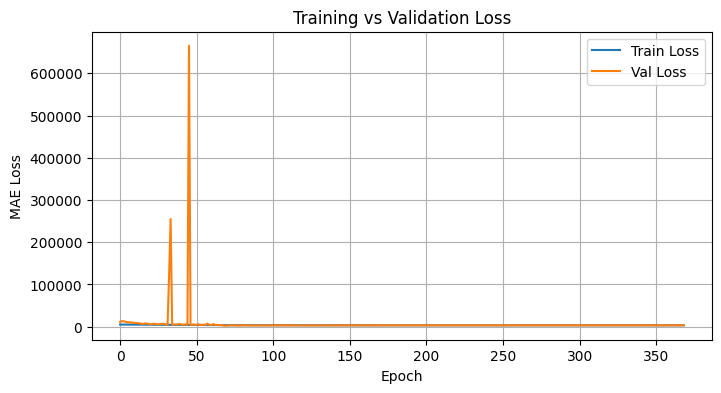

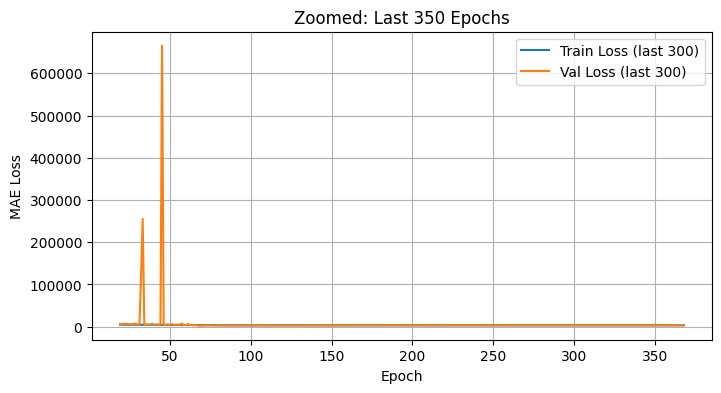

In [75]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, callbacks, optimizers
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def train_neural_network(X_train,y_train,X_test,y_test, random_state=42, verbose=1):

    model = models.Sequential([
        layers.Input(shape=(X_train.shape[1],)),

        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(1e-5)),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.GaussianNoise(0.01),

        layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-5)),
        layers.BatchNormalization(),
        layers.Dropout(0.1),

        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-5)),
        layers.BatchNormalization(),
        layers.Dropout(0.1),

        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-5)),
        layers.BatchNormalization(),
        layers.Dropout(0.1),

        layers.Dense(1, activation='linear')
    ])

    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-3),
        loss='mse',
        metrics=['mae', 'mse']
    )

    es = callbacks.EarlyStopping(monitor='val_loss', patience=300, restore_best_weights=True)
    lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=15, min_lr=1e-20)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=4000,
        batch_size=256,
        callbacks=[es, lr],
        verbose=verbose
    )

    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f"\nPerformance on Test Data:")
    print(f"R² Score: {r2:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")

    history_df = pd.DataFrame(history.history)
    plt.figure(figsize=(8, 4))
    plt.plot(history_df['loss'], label='Train Loss')
    plt.plot(history_df['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MAE Loss')
    plt.legend()
    plt.title('Training vs Validation Loss')
    plt.grid(True)
    plt.show()

    zoom_window = 350
    start_idx = max(len(history_df) - zoom_window, 0)

    plt.figure(figsize=(8, 4))
    plt.plot(history_df['loss'].iloc[start_idx:], label='Train Loss (last 300)')
    plt.plot(history_df['val_loss'].iloc[start_idx:], label='Val Loss (last 300)')
    plt.xlabel('Epoch')
    plt.ylabel('MAE Loss')
    plt.title(f'Zoomed: Last {zoom_window} Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

    return model, history_df

neural,_ = train_neural_network(X_train,y_train,X_val,y_val)

## __STACKING BOOSTING__

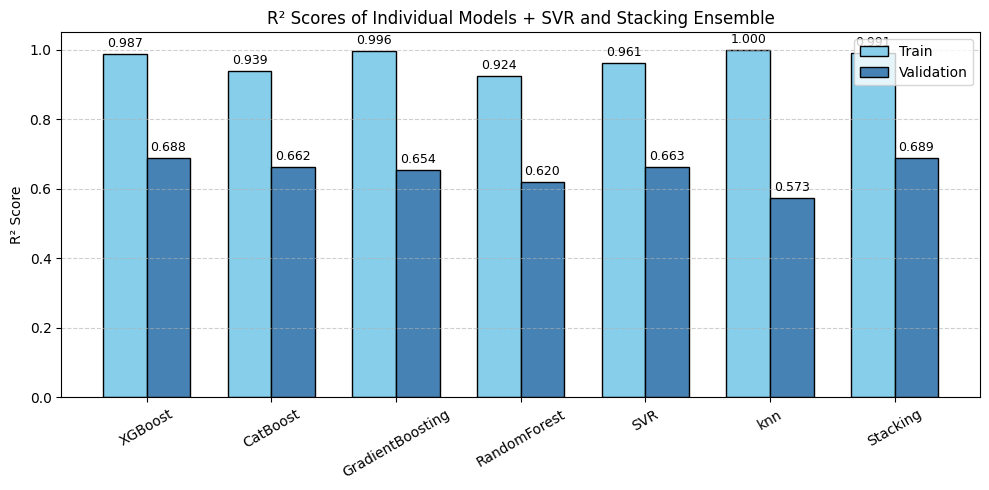

In [ ]:
# --- Imports ---
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import StackingRegressor, GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C


# --- Ensure y is ravelled ---
y_train = np.ravel(y_train)
y_val = np.ravel(y_val)

# --- Base models with solid parameters ---
xgb = XGBRegressor(
    n_estimators=1200,
    learning_rate=0.03,
    max_depth=3,
    subsample=0.65,
    colsample_bytree=0.7,
    reg_alpha=0.7,
    reg_lambda=2.0,
    random_state=42,
    objective='reg:squarederror',
    verbosity=0
)

# CatBoost
cat = CatBoostRegressor(
    iterations=1200,
    learning_rate=0.02,
    depth=6,
    l2_leaf_reg=10,
    random_seed=42,
    verbose=0
)

# Gradient Boosting
gbr = GradientBoostingRegressor(
    n_estimators=1200,
    learning_rate=0.02,
    max_depth=4,
    subsample=0.8,
    min_samples_leaf=4,
    random_state=42
)

# Random Forest
rf = RandomForestRegressor(
    n_estimators=800,
    max_depth=None,
    min_samples_split=4,
    min_samples_leaf=2,
    max_features='sqrt',
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)

# SVR
svr = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR(kernel='rbf', C=24, epsilon=0.05))
])

# KNN
knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor(n_neighbors=3, weights='distance'))
])

# --- Stacking Ensemble including SVR ---
estimators = [
    ('xgb', xgb),
    ('cat', cat),
    ('gbr', gbr),
    ('rf', rf),
    ('svr', svr),
    ('knn', knn),
]

stack_model = StackingRegressor(
    estimators=estimators,
    final_estimator=Ridge(alpha=15.0),
    passthrough=False,
    n_jobs=-1
)

# --- List of all models for evaluation ---
models = [
    ('XGBoost', xgb),
    ('CatBoost', cat),
    ('GradientBoosting', gbr),
    ('RandomForest', rf),
    ('SVR', svr),
    ('knn', knn),
    ('Stacking', stack_model)
]

# --- Train, predict, and compute R² ---
r2_train_list = []
r2_val_list = []
predictions_val = {}

for name, model in models:
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)

    r2_train_list.append(r2_score(y_train, y_pred_train))
    r2_val_list.append(r2_score(y_val, y_pred_val))

    predictions_val[name] = y_pred_val

# --- Plot R² bar chart ---
x = np.arange(len(models))
width = 0.35
fig, ax = plt.subplots(figsize=(10, 5))
rects1 = ax.bar(x - width/2, r2_train_list, width, label='Train', color='skyblue', edgecolor='k')
rects2 = ax.bar(x + width/2, r2_val_list, width, label='Validation', color='steelblue', edgecolor='k')

ax.set_ylabel('R² Score')
ax.set_xticks(x)
ax.set_xticklabels([name for name, _ in models], rotation=30)
ax.set_title('R² Scores of Individual Models + SVR and Stacking Ensemble')
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.6)

# Annotate bars
for rects in [rects1, rects2]:
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


In [57]:
X_new_df = pd.read_csv("X_test.csv")  
ids = X_new_df['id'].to_numpy()

y_pred_test = stack_model.predict(X_test_final)

submission_df = pd.DataFrame({
    'id': ids,
    'y': y_pred_test
})

submission_df.to_csv("submission75.csv", index=False)
print("Submission file saved as submission75.csv")

Submission file saved as submission75.csv


## __TEST MODEL ON UNSEEN DATA AND CREATE SUBMISSION FILE__

In [60]:
import csv

file1 = "submission54.csv"
file2 = "submission75.csv"

with open(file1) as f1, open(file2) as f2:
    reader1 = csv.reader(f1)
    reader2 = csv.reader(f2)
    
    header1 = next(reader1)
    header2 = next(reader2)
    
    print(f"{header1[0]:<5} {header1[1]:<20}  {'Difference':<20}")
    
    for row1, row2 in zip(reader1, reader2):
        id1, y1 = row1
        id2, y2 = row2
        y1 = float(y1)
        y2 = float(y2)
        diff = abs(y1 - y2)
        print(f"{id1:<5} {y1:<20} {diff:<20}")


id    y                     Difference          
0.0   60.7427892588709     1.3136764515137003  
1.0   75.41121522364595    0.2192641897654397  
2.0   71.05706980923367    0.7632557732158602  
3.0   75.81508916736904    0.23348343700367025 
4.0   72.0371771040238     1.9800708789498884  
5.0   57.368335189030034   2.558814771823833   
6.0   63.45459756804729    1.9356342734010354  
7.0   70.46877863187585    2.654694118112573   
8.0   69.7046076494951     1.0521738715277849  
9.0   55.74779707378808    2.84105472384681    
10.0  77.30177800856212    0.27308747284739354 
11.0  74.59202036074264    0.7487795601951035  
12.0  52.12881258662534    1.8139514910075434  
13.0  71.56129231798501    0.32466563056435405 
14.0  76.16233932594099    0.41273338993090647 
15.0  67.61583467784116    1.2706667282630377  
16.0  76.48415869845063    0.636930320559344   
17.0  71.52246830864264    1.3828313205278278  
18.0  68.47768296512393    0.24250920380357854 
19.0  62.942234693067746   4.4602387659